In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
sys.path.append('..')
from Dataset_Loader_Node_Classification import Dataset_Loader
from gcn.models import GCN
from gcn.utils import accuracy

In [2]:
data_loader = Dataset_Loader(dName='pubmed', dDescription='Pubmed citation network')
data_loader.dataset_name = 'pubmed'
data_loader.dataset_source_folder_path = '../stage_5_data/pubmed/'

import os

data_loader.data_path = '../stage_5_data/pubmed/'

if not os.path.exists(data_loader.data_path):
	raise FileNotFoundError(f"Data path does not exist: {data_loader.data_path}")

loaded_data = data_loader.load()

graph_data = loaded_data['graph']
train_test_val_indices = loaded_data['train_test_val']

adj = graph_data['utility']['A']
features = graph_data['X']
labels = graph_data['y']

idx_train = train_test_val_indices['idx_train']
idx_val = train_test_val_indices['idx_val']
idx_test = train_test_val_indices['idx_test']

print("Data Loaded:")
print(f"  Features shape: {features.shape}")
print(f"  Adjacency matrix shape: {adj.shape}")
print(f"  Labels shape: {labels.shape}")
print(f"  Number of training samples: {len(idx_train)}")
print(f"  Number of validation samples: {len(idx_val)}")
print(f"  Number of testing samples: {len(idx_test)}")

Loading pubmed dataset...
Data Loaded:
  Features shape: torch.Size([19717, 500])
  Adjacency matrix shape: torch.Size([19717, 19717])
  Labels shape: torch.Size([19717])
  Number of training samples: 60
  Number of validation samples: 300
  Number of testing samples: 1000


/Users/atticus/atwong@ucdavis.edu/ECS189G/stage-5-189/_Pubmed/../Dataset_Loader_Node_Classification.py:35: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/torch/csrc/utils/tensor_new.cpp:653.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [3]:
n_epochs = 200
lr = 0.01
weight_decay = 5e-4
hidden_units = 16
dropout_rate = 0.5
cuda_available = torch.cuda.is_available()

n_features = features.shape[1]
n_classes = labels.max().item() + 1

model = GCN(nfeat=n_features,
            nhid=hidden_units,
            nclass=n_classes,
            dropout=dropout_rate)

optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)

if cuda_available:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

print("Model Initialized:")
print(model)

Model Initialized:
GCN(
  (gc1): GraphConvolution (500 -> 16)
  (gc2): GraphConvolution (16 -> 3)
)


In [4]:
import time

def train_epoch(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    
    output = model(features, adj) 
    
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    
    loss_train.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        output_val = model(features, adj)
        loss_val = F.nll_loss(output_val[idx_val], labels[idx_val])
        acc_val = accuracy(output_val[idx_val], labels[idx_val])

    print(f'Epoch: {epoch+1:04d}',
          f'loss_train: {loss_train.item():.4f}',
          f'acc_train: {acc_train.item():.4f}',
          f'loss_val: {loss_val.item():.4f}',
          f'acc_val: {acc_val.item():.4f}',
          f'time: {time.time() - t:.4f}s')
    return loss_train.item(), loss_val.item(), acc_train.item(), acc_val.item()

print("Starting Training...")
t_total = time.time()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
loss_train_history = []
loss_val_history = []
acc_train_history = []
acc_val_history = []
for epoch in range(n_epochs):
    loss_train, loss_val, acc_train, acc_val = train_epoch(epoch)
    loss_train_history.append(loss_train)
    loss_val_history.append(loss_val)
    acc_train_history.append(acc_train)
    acc_val_history.append(acc_val)
    
    scheduler.step()

print("Optimization Finished!")
print(f"Total time elapsed: {time.time() - t_total:.4f}s")

Starting Training...
Epoch: 0001 loss_train: 1.1372 acc_train: 0.3333 loss_val: 1.0702 acc_val: 0.4200 time: 0.0948s
Epoch: 0002 loss_train: 1.1274 acc_train: 0.3167 loss_val: 1.0619 acc_val: 0.4333 time: 0.0206s
Epoch: 0003 loss_train: 1.0968 acc_train: 0.3833 loss_val: 1.0566 acc_val: 0.4400 time: 0.0195s
Epoch: 0004 loss_train: 1.0954 acc_train: 0.3833 loss_val: 1.0538 acc_val: 0.4433 time: 0.0195s
Epoch: 0005 loss_train: 1.0603 acc_train: 0.4167 loss_val: 1.0527 acc_val: 0.4467 time: 0.0187s
Epoch: 0006 loss_train: 1.0403 acc_train: 0.4333 loss_val: 1.0522 acc_val: 0.4767 time: 0.0220s
Epoch: 0007 loss_train: 1.0484 acc_train: 0.4833 loss_val: 1.0519 acc_val: 0.5167 time: 0.0231s
Epoch: 0008 loss_train: 1.0354 acc_train: 0.5333 loss_val: 1.0511 acc_val: 0.5767 time: 0.0222s
Epoch: 0009 loss_train: 1.0134 acc_train: 0.5167 loss_val: 1.0497 acc_val: 0.6133 time: 0.0260s
Epoch: 0010 loss_train: 1.0106 acc_train: 0.6833 loss_val: 1.0470 acc_val: 0.6200 time: 0.0195s
Epoch: 0011 loss_tr

In [5]:
def test_model():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("\nTest set results:",
          f"loss= {loss_test.item():.4f}",
          f"accuracy= {acc_test.item():.4f}")

print("\nEvaluating on Test Set...")
test_model()


Evaluating on Test Set...

Test set results: loss= 0.5873 accuracy= 0.7880


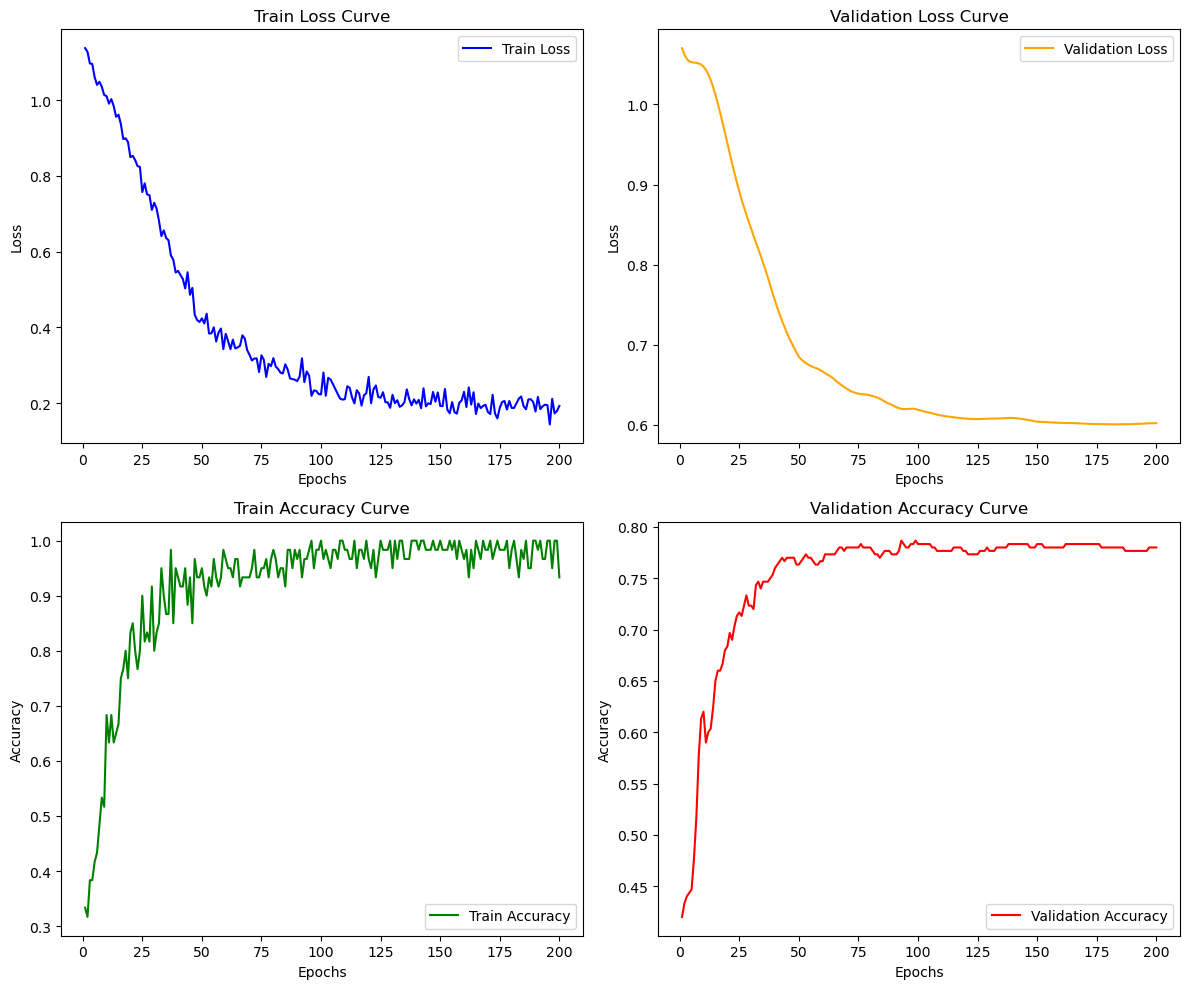

In [7]:
import matplotlib.pyplot as plt
# Plotting Learning Curves with separate graphs for each metric
plt.figure(figsize=(12, 10))  # Adjusted figure size for 4 plots

# Plot 1: Train Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, 201), loss_train_history, label='Train Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss Curve')

# Plot 2: Validation Loss
plt.subplot(2, 2, 2)
plt.plot(range(1, 201), loss_val_history, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Curve')

# Plot 3: Train Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, 201), acc_train_history, label='Train Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy Curve')

# Plot 4: Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(range(1, 201), acc_val_history, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Curve')

plt.tight_layout()
plt.show()